In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook
import seaborn as sns
import pickle
from gryffin import Gryffin
from chimera import Chimera

from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

sns.set(style='ticks', context='notebook', font_scale=1.2)

tolerances = [1., 0.]
chimera = Chimera(tolerances=tolerances, absolutes=[True, True], goals=['max', 'min'])


In [6]:
with open('random/results.pkl', 'rb') as content:
    data_random = pickle.load(content)
    
with open('deap/results.pkl', 'rb') as content:
    data_deap = pickle.load(content)
    
with open('opt_adam/results.pkl', 'rb') as content:
    data_adam = pickle.load(content)
    
with open('opt_genetic/results.pkl', 'rb') as content:
    data_gene = pickle.load(content)
    
with open('gpyopt/results.pkl', 'rb') as content:
    data_gpyopt = pickle.load(content)
    
print('N random:', len(data_random))
print('N deap:', len(data_deap))
print('N Gryffin (Adam, prior):', len(data_adam))
print('N Gryffin (Gene, prior):', len(data_gene))
print('N GPyOpt :', len(data_gpyopt))

N random: 100
N deap: 100
N Gryffin (Adam, prior): 100
N Gryffin (Gene, prior): 100
N GPyOpt : 100


In [13]:
def plot_trace_mean(data, obj_num=0, ax=None, color=None, linestyle='-', unc=True, alpha_line=1., alpha_unc=0.2,
                    label=None, use_std_err=True, outline=True):
    traces = get_traces(data)[:, obj_num, :]
    
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    if outline is True:
        ax.plot(x, mean, color='#444444', linewidth=5, alpha=alpha_line)
    ax.plot(x, mean, color=color, linestyle=linestyle, linewidth=4, label=label, alpha=alpha_line)
    
    if unc is True:
        ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=alpha_unc, color=color)
        ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
def get_traces(data):
    traces = []
    for df in data:
        scalarized = chimera.scalarize(df.loc[:, ['obj0', 'obj1']])

        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'obj0'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'obj1'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'MA'] for i in trace_best_idx]
        trace3 = [df.loc[i, 'BA'] for i in trace_best_idx]
        
        traces.append([trace0, trace1, trace2, trace3])
    return np.array(traces)

def get_traces_verbose(data):
    traces = []
    for df in data:
        scalarized = chimera.scalarize(df.loc[:, ['obj0', 'obj1']])

        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'obj0'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'obj1'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'MA'] for i in trace_best_idx]
        trace3 = [df.loc[i, 'BA'] for i in trace_best_idx]
        c60 = [df.loc[i, 'c60_flow'] for i in trace_best_idx]
        sultine = [df.loc[i, 'sultine_flow'] for i in trace_best_idx]
        T = [df.loc[i, 'T'] for i in trace_best_idx]
        
        traces.append([c60, sultine, T, trace0, trace1, trace2, trace3])
    return np.array(traces)

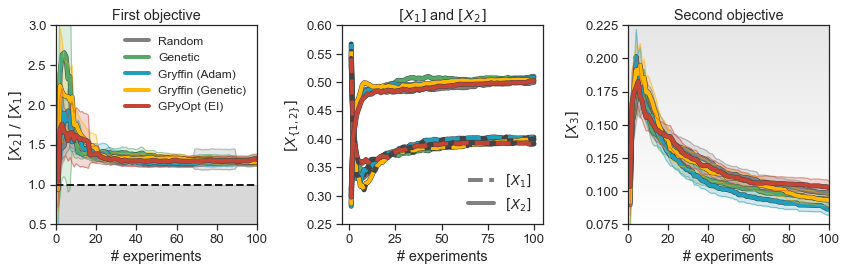

In [18]:
# MAKE SI PLOT --> all traces including GPyOpt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=False, sharey=False)

plot_trace_mean(data_random, obj_num=0, ax=axes[0], color='gray', label='Random')
plot_trace_mean(data_random, obj_num=2, ax=axes[1], color='gray', linestyle='--', unc=False, label='$[X_1]$')
plot_trace_mean(data_random, obj_num=3, ax=axes[1], color='gray', linestyle='-', unc=False, label='$[X_2]$')
plot_trace_mean(data_random, obj_num=1, ax=axes[2], color='gray', label='Random')

plot_trace_mean(data_deap, obj_num=0, ax=axes[0], color='g', label='Genetic')
plot_trace_mean(data_deap, obj_num=2, ax=axes[1], color='g', linestyle='--', unc=False)
plot_trace_mean(data_deap, obj_num=3, ax=axes[1], color='g', linestyle='-', unc=False)
plot_trace_mean(data_deap, obj_num=1, ax=axes[2], color='g', label='Genetic')

# Gryffin (Adam) #f07167
plot_trace_mean(data_adam, obj_num=0, ax=axes[0], color='#219ebc', label='Gryffin (Adam)')
plot_trace_mean(data_adam, obj_num=2, ax=axes[1], color='#219ebc', linestyle='--', unc=False)
plot_trace_mean(data_adam, obj_num=3, ax=axes[1], color='#219ebc', linestyle='-', unc=False)
plot_trace_mean(data_adam, obj_num=1, ax=axes[2], color='#219ebc', label='Gryffin (Adam)')

# Gryffin (Genetic) #fc9636
plot_trace_mean(data_gene, obj_num=0, ax=axes[0], color='#ffb703', label='Gryffin (Genetic)')
plot_trace_mean(data_gene, obj_num=2, ax=axes[1], color='#ffb703', linestyle='--', unc=False)
plot_trace_mean(data_gene, obj_num=3, ax=axes[1], color='#ffb703', linestyle='-', unc=False)
plot_trace_mean(data_gene, obj_num=1, ax=axes[2], color='#ffb703', label='Gryffin (Genetic)')

# GPyOpt #c44536
plot_trace_mean(data_gpyopt, obj_num=0, ax=axes[0], color='#c44536', label='GPyOpt (EI)')
plot_trace_mean(data_gpyopt, obj_num=2, ax=axes[1], color='#c44536', linestyle='--', unc=False)
plot_trace_mean(data_gpyopt, obj_num=3, ax=axes[1], color='#c44536', linestyle='-', unc=False)
plot_trace_mean(data_gpyopt, obj_num=1, ax=axes[2], color='#c44536', label='GPyOpt (EI)')


axes[0].fill_between(x=[0,100], y1=0., y2=tolerances[0], alpha=0.3, color='gray')
axes[0].axhline(y=tolerances[0], linestyle='--', color='k', linewidth=2, zorder=2)
gradient_patch(ax=axes[2], xmin=0, xmax=100, ymin=0.075, ymax=0.225, fill_color='gray', alpha=0.2)


axes[0].set_ylim([0.5, 3])
axes[1].set_ylim([0.25, 0.60])
axes[2].set_ylim([0.075, 0.225])

#axes[0].set_ylim([0.75, 2.75 ])
axes[0].set_xlim([0,100])

axes[0].legend(frameon=False, ncol=1, fontsize=12, loc='upper right')
axes[1].legend(frameon=False)
#axes[2].legend(frameon=False)

axes[0].set_xlabel('# experiments')
axes[1].set_xlabel('# experiments')
axes[2].set_xlabel('# experiments')

axes[0].set_ylabel('$[X_2]\ /\ [X_1]$')
axes[1].set_ylabel('$[X_{\{1,2\}}]$')
axes[2].set_ylabel('$[X_3]$')

axes[0].set_title("First objective")
axes[1].set_title("$[X_1]$ and $[X_2]$")
axes[2].set_title("Second objective")

plt.tight_layout()
fig.savefig('fullerenes-results-full-si.pdf', bbox_inches='tight')
fig.savefig('fullerenes-results-full-si.png', dpi=300, bbox_inches='tight')